In [1]:
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
import torch

#quantization_config = BitsAndBytesConfig(load_in_8bit=True,)
#quantization_config = BitsAndBytesConfig(load_in_8bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    #quantization_config=quantization_config
)
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj"],
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mehdi/Desktop/aut/pkgs/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running on cuda
trainable params: 2,621,440 || all params: 3,747,301,376 || trainable%: 0.0700


In [2]:
import os
import pandas as pd
from datasets import Dataset
import torch
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from io import BytesIO

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    # Stack the pixel values
    pixel_values = torch.stack(pixel_values)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'pixel_values': pixel_values, 'labels': labels}

# Define the dataset class
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_folder, processor):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']
        question = row['question']
        answer = row['answer']
        
        # Load image
        image_path = os.path.join(self.image_folder, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")
        
        # Process image and text, make sure attention_mask is returned
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")
        encoding['attention_mask'] = encoding['attention_mask'].squeeze()  # Ensure attention_mask is available

        labels = self.processor.tokenizer.encode(
            answer, max_length=8, pad_to_max_length=True, return_tensors='pt'
        )
        
        encoding["labels"] = labels.squeeze()
        for k, v in encoding.items():
            encoding[k] = v.squeeze()
        
        return encoding

# Load the question-answer pairs
data_path = "/home/mehdi/Desktop/aut/blip2/ImageClef-2019-VQA-Med-Training/QAPairsByCategory/C4_Abnormality_train.txt"
image_folder = "ImageClef-2019-VQA-Med-Training/Train_images"

# Read the data
data = []
with open(data_path, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 3:
            image_id, question, answer = parts
            data.append({'image_id': image_id, 'question': question, 'answer': answer})

# validation
data_path = "/home/mehdi/Desktop/aut/blip2/ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/C4_Abnormality_val.txt"
image_folder_val = "ImageClef-2019-VQA-Med-Validation/Val_images"
data_val = []
with open(data_path, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 3:
            image_id, question, answer = parts
            data_val.append({'image_id': image_id, 'question': question, 'answer': answer})

df = pd.DataFrame(data)
df_val = pd.DataFrame(data_val)

# Split into train and validation sets
#train_df = df.sample(frac=0.9, random_state=42)
#valid_df = df.drop(train_df.index)

# Create dataset instances
train_dataset = VQADataset(dataframe=df, image_folder=image_folder, processor=processor)
valid_dataset = VQADataset(dataframe=df_val, image_folder=image_folder_val, processor=processor)

# Data loaders
batch_size = 8

# Use the custom collate function in DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, collate_fn=collate_fn)



In [3]:
batch = next(iter(train_dataloader))

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/mehdi/Desktop/aut/pkgs/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In th

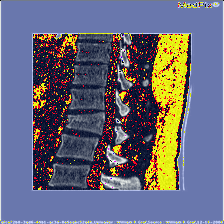

In [4]:
from PIL import Image
import numpy as np
image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std
batch_idx = 3
unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 50
patience = 3
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()
loss_list = []

# Move model to the device (CUDA or CPU)
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
        
        epoch_loss += loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        loss_list.append(loss.item())
        #print(f"Loss: {loss.item()}")

    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc=f"Validating Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels, attention_mask=attention_mask)
                loss = outputs.loss
            
            eval_loss += loss.item()

    train_loss = epoch_loss / len(train_dataloader)
    valid_loss = eval_loss / len(valid_dataloader)
    tracking_information.append((train_loss, valid_loss, optimizer.param_groups[0]["lr"]))
    print(f"Epoch: {epoch+1} - Training loss: {train_loss:.4f} - Validation loss: {valid_loss:.4f} - LR: {optimizer.param_groups[0]['lr']:.4e}")
    
    scheduler.step()
    
    if valid_loss < min_eval_loss:
        model.save_pretrained("Model_2/blip-saved-model")
        print("Saved model to Model_2/blip-saved-model")
        min_eval_loss = valid_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            print("Early stopping triggered.")
            break

pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process is complete!")


/tmp/ipykernel_34729/810959413.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training Epoch 1:   0%|          | 0/399 [00:00<?, ?it/s]/tmp/ipykernel_34729/810959413.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_34729/810959413.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating Epoch 1: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Epoch: 1 - Training loss: 8.6725 - Validation loss: 7.5224 - LR: 4.0000e-05
Saved model to Model_2/blip-saved-model


Validating Epoch 2: 100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


Epoch: 2 - Training loss: 7.1547 - Validation loss: 7.0682 - LR: 3.6000e-05
Saved model to Model_2/blip-saved-model


Validating Epoch 3: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Epoch: 3 - Training loss: 6.8813 - Validation loss: 6.8670 - LR: 3.2400e-05
Saved model to Model_2/blip-saved-model


Validating Epoch 4: 100%|██████████| 63/63 [01:26<00:00,  1.38s/it]


Epoch: 4 - Training loss: 6.7022 - Validation loss: 6.6485 - LR: 2.9160e-05
Saved model to Model_2/blip-saved-model


Validating Epoch 5: 100%|██████████| 63/63 [01:25<00:00,  1.35s/it]


Epoch: 5 - Training loss: 6.5780 - Validation loss: 6.5295 - LR: 2.6244e-05
Saved model to Model_2/blip-saved-model


Training Epoch 6:  34%|███▎      | 134/399 [03:45<07:20,  1.66s/it]

In [6]:
model.save_pretrained("Model_2/blip-saved-model")

In [7]:
# write tracking_information to a csv file
import csv

with open('tracking_information_blip2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["train_loss", "valid_loss", "learning_rate"])
    for row in tracking_information:
        writer.writerow(row)

In [8]:
# write tracking_information to a csv file
import csv

with open('track_info_loss_values_blip2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for number in loss_list:
        writer.writerow([number]) # Writing the list as a row


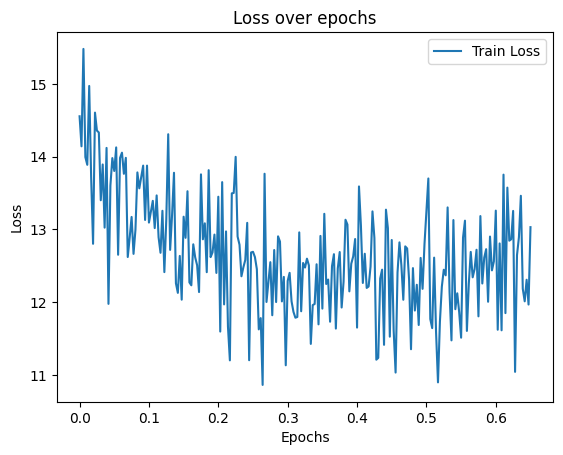

In [9]:
# Plot the loss and save it as a png
import matplotlib.pyplot as plt

Loss_list_epochs = [i/len(train_dataloader) for i in range(len(loss_list))]
plt.plot(Loss_list_epochs, loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.savefig('Loss_over_epochs.png')

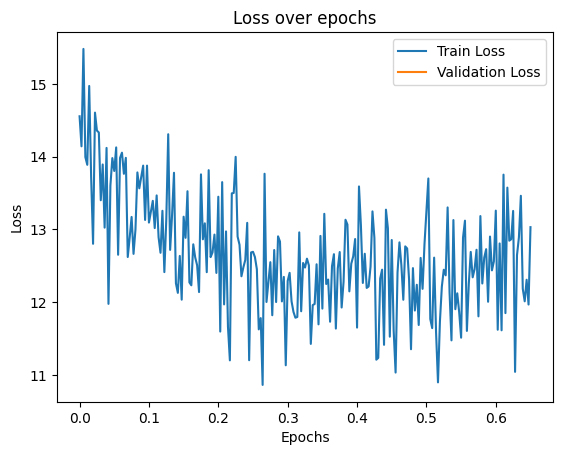

In [10]:
# Plot the loss and save it as a png
import matplotlib.pyplot as plt
n = [row[1] for row in tracking_information]
plt.plot(Loss_list_epochs, loss_list, label='Train Loss')
plt.plot(range(len(n)), n, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.savefig('Loss_train_and_validation_over_epochs_after_1824.png')

In [12]:
!pip install wheel


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached wheel-0.44.0-py3-none-any.whl (67 kB)


In [2]:
!pip install -q datasets timm einops

In [1]:
!pip install -q flash_attn